In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify


In [2]:
orders = pd.read_csv("orders.csv")
prior = pd.read_csv("order_products__prior.csv")
train = pd.read_csv("order_products__train.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")

# concat prior and train
orders_all = pd.concat([prior, train], ignore_index=True)

# merge products
product_full = (
    products
    .merge(aisles, on="aisle_id", how="left")
    .merge(departments, on="department_id", how="left")
)

# merge all
full_data = (
    orders_all
    .merge(product_full, on="product_id", how="left")
    .merge(orders, on="order_id", how="left")
)

# check
print(full_data.shape)
print(full_data.columns)
full_data.head()


(33819106, 15)
Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [3]:
print(full_data.shape)
print(full_data.info())

# datatype distribution
full_data.dtypes.value_counts()

(33819106, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   aisle                   object 
 8   department              object 
 9   user_id                 int64  
 10  eval_set                object 
 11  order_number            int64  
 12  order_dow               int64  
 13  order_hour_of_day       int64  
 14  days_since_prior_order  float64
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB
None


int64      10
object      4
float64     1
Name: count, dtype: int64

In [4]:
# missing value
missing = full_data.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing_percent = (missing / len(full_data) * 100).round(2)
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
print(missing_df)



                        Missing Values  Percent
days_since_prior_order         2078068     6.14


Since PCA cannot directly process NaN values, columns with a higher proportion of missing data may introduce false patterns. Therefore, we imputed missing categorical values with ‘-1’.

In [5]:
full_data['days_since_prior_order'].fillna(-1, inplace=True)
full_data['aisle'].fillna('Unknown', inplace=True)
full_data['department'].fillna('Unknown', inplace=True)

C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\1658442424.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_data['days_since_prior_order'].fillna(-1, inplace=True)
C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\1658442424.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [6]:
# describe stat
num_cols = ['order_dow','order_hour_of_day','days_since_prior_order','add_to_cart_order']
full_data[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
order_dow,33819106.0,2.737285,2.093296,0.0,1.0,3.0,5.0,6.0
order_hour_of_day,33819106.0,13.431226,4.246149,0.0,10.0,13.0,16.0,23.0
days_since_prior_order,33819106.0,10.604418,9.156268,-1.0,4.0,7.0,15.0,30.0
add_to_cart_order,33819106.0,8.367738,7.139540,1.0,3.0,6.0,11.0,145.0


In [7]:
#fig, axes = plt.subplots(2, 2, figsize=(12,8))
#for i, col in enumerate(num_cols):
#    sns.histplot(full_data[col], bins=30, kde=True, ax=axes[i//2, i%2], color='skyblue')
#    axes[i//2, i%2].set_title(f'Distribution of {col}')
#plt.tight_layout()
#plt.show()


In [8]:
user_orders = full_data.groupby('user_id').agg(
    total_orders=('order_number','max'),
    avg_days_between_orders=('days_since_prior_order','mean')
).reset_index()
user_orders

,user_id,total_orders,avg_days_between_orders
0,1,11,17.757143
1,2,15,16.915929
2,3,12,10.068182
3,4,5,11.722222
4,5,5,9.130435
...,...,...,...
206204,206205,4,9.470588
206205,206206,67,3.971930
206206,206207,16,13.170404
206207,206208,49,7.292467


In [9]:
user_time = full_data.groupby('user_id').agg(
    avg_order_hour=('order_hour_of_day','mean'),
    most_common_order_dow=('order_dow', lambda x: x.mode()[0])
).reset_index()
user_time

,user_id,avg_order_hour,most_common_order_dow
0,1,10.142857,4
1,2,10.517699,1
2,3,16.352273,0
3,4,13.111111,4
4,5,14.804348,0
...,...,...,...
206204,206205,14.509804,1
206205,206206,16.796491,0
206206,206207,13.130045,1
206207,206208,13.968981,2


In [10]:
user_reorder = full_data.groupby('user_id').agg(
    reorder_rate=('reordered','mean')
).reset_index()
user_reorder

,user_id,reorder_rate
0,1,0.728571
1,2,0.464602
2,3,0.625000
3,4,0.055556
4,5,0.391304
...,...,...
206204,206205,0.274510
206205,206206,0.473684
206206,206207,0.587444
206207,206208,0.707533


In [11]:
user_cart = full_data.groupby(['user_id','order_id']).size().groupby('user_id').agg(
    avg_cart_size='mean',
    max_cart_size='max'
).reset_index()
user_cart

,user_id,avg_cart_size,max_cart_size
0,1,6.363636,11
1,2,15.066667,31
2,3,7.333333,11
3,4,3.600000,7
4,5,9.200000,12
...,...,...,...
206204,206205,12.750000,19
206205,206206,4.253731,24
206206,206207,13.937500,25
206207,206208,13.816327,28


In [12]:
cat_cols = ['department', 'aisle', 'reordered']
for c in cat_cols:
    print(f"{c} unique values:", full_data[c].nunique())
    print(full_data[c].value_counts(normalize=True).head(), "\n")

department unique values: 21
department
produce       0.292390
dairy eggs    0.166505
snacks        0.088897
beverages     0.082917
frozen        0.069099
Name: proportion, dtype: float64 

aisle unique values: 134
aisle
fresh fruits                  0.112146
fresh vegetables              0.105521
packaged vegetables fruits    0.054520
yogurt                        0.044578
packaged cheese               0.030204
Name: proportion, dtype: float64 

reordered unique values: 2
reordered
1    0.590062
0    0.409938
Name: proportion, dtype: float64 



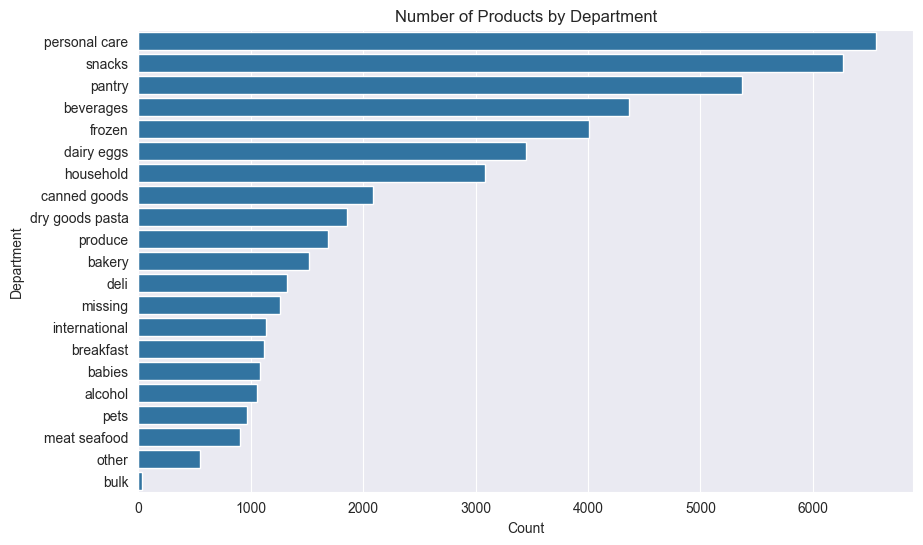

In [13]:
plt.figure(figsize=(10,6))
sns.countplot(y='department', data=product_full, order=product_full['department'].value_counts().index)
plt.title("Number of Products by Department")
plt.xlabel("Count")
plt.ylabel("Department")
plt.show()

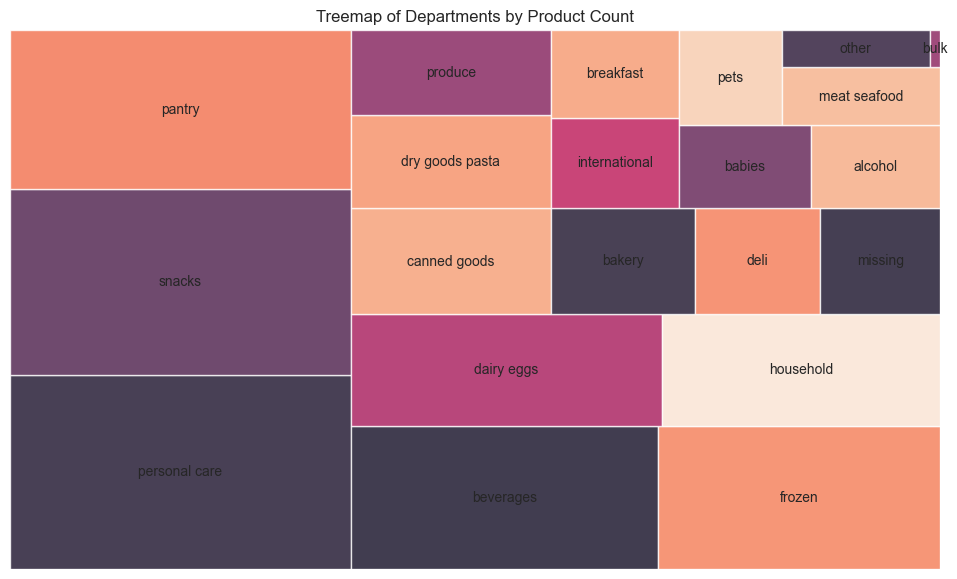

In [14]:
dept_counts = product_full['department'].value_counts()
plt.figure(figsize=(12,7))
squarify.plot(sizes=dept_counts.values, label=dept_counts.index, alpha=0.8)
plt.title("Treemap of Departments by Product Count")
plt.axis('off')
plt.show()


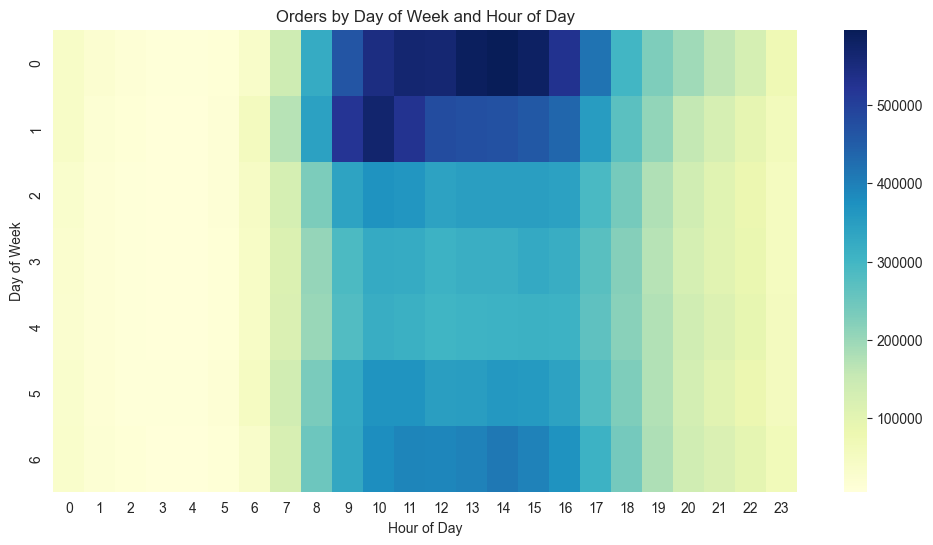

In [15]:
heat = full_data.groupby(['order_dow','order_hour_of_day']).size().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(heat, cmap='YlGnBu')
plt.title("Orders by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

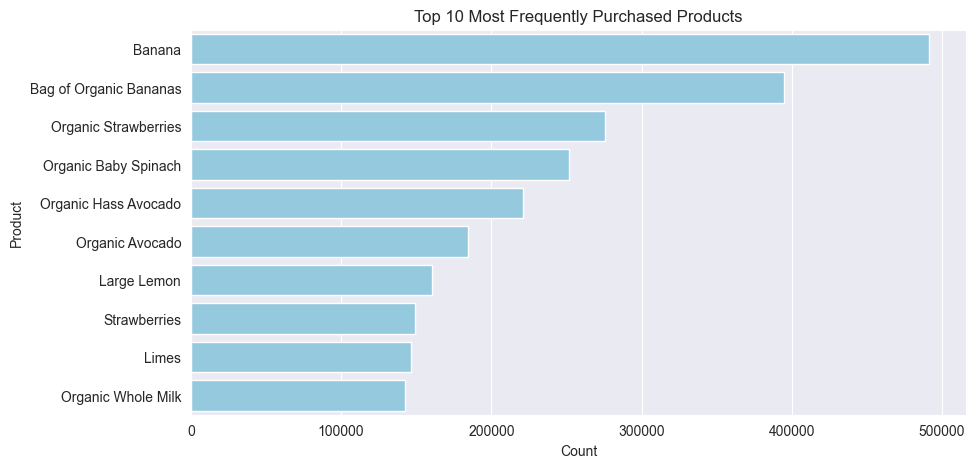

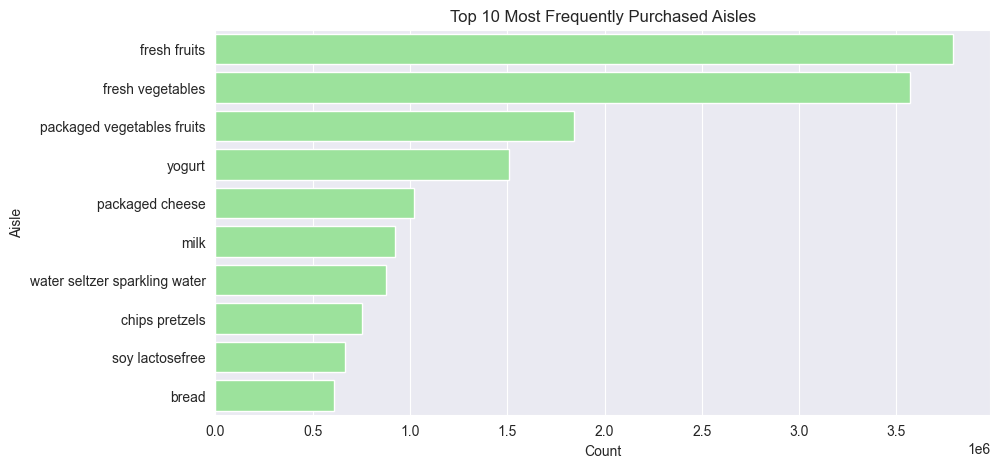

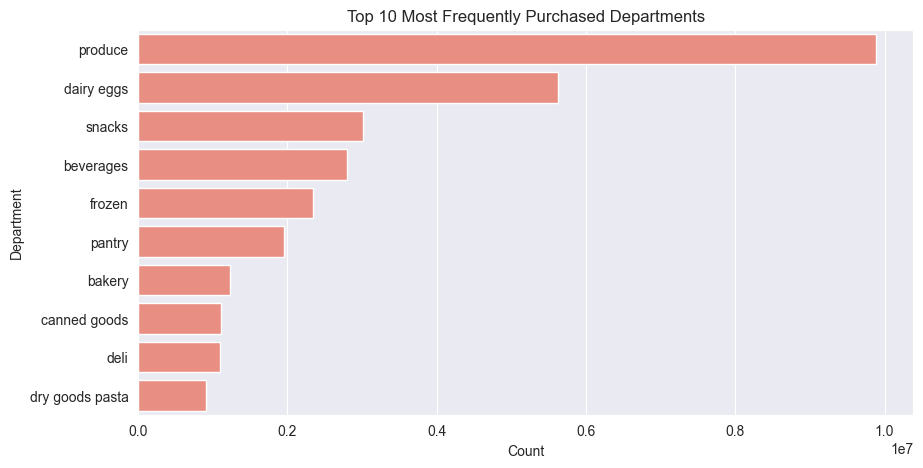

In [16]:
top_products = full_data['product_name'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index, color='skyblue')
plt.title("Top 10 Most Frequently Purchased Products")
plt.xlabel("Count")
plt.ylabel("Product")
plt.show()

top_aisles = full_data['aisle'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_aisles.values, y=top_aisles.index, color='lightgreen')
plt.title("Top 10 Most Frequently Purchased Aisles")
plt.xlabel("Count")
plt.ylabel("Aisle")
plt.show()

top_departments = full_data['department'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_departments.values, y=top_departments.index, color='salmon')
plt.title("Top 10 Most Frequently Purchased Departments")
plt.xlabel("Count")
plt.ylabel("Department")
plt.show()

Question: segment customers based on their purchase behavior and understand what kinds of products each group tends to buy repeatedly

Clustering analysis First Version (can delete)

In [52]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, KMeans

In [17]:
print(f"There are {full_data.department.nunique()} Departments, "
      f"{full_data.product_name.nunique()} Products, "
      f"{full_data.aisle.nunique()} Aisles, "
      f"and {full_data.user_id.nunique()} unique Customers")


There are 21 Departments, 49685 Products, 134 Aisles, and 206209 unique Customers


In [18]:
# only prior + train
hist = full_data[full_data['eval_set'].isin(['prior', 'train'])].copy()


In [19]:
user_aisle = pd.crosstab(hist['user_id'], hist['aisle'])
print(f"user_aisle shape: {user_aisle.shape}")


user_aisle shape: (206209, 134)


In [22]:
#standarization Z-score
scaler = StandardScaler(with_mean=False)
user_aisle_scaled = scaler.fit_transform(user_aisle)

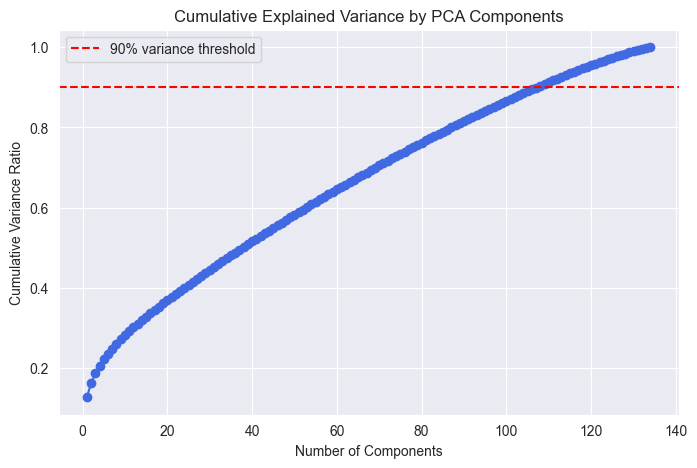

In [25]:
# PCA (n_components)

pca_full = PCA().fit(user_aisle_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', color='royalblue')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance threshold')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.legend()
plt.show()

In [27]:
# n_components
n_components = np.argmax(cum_var >= 0.9) + 1
print(f"Selected n_components = {n_components}")


Selected n_components = 108


In [30]:
# PCA
# ===============================================
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(user_aisle_scaled)
print(f"PCA dimensionality reduction: {X_pca.shape}")



explained_ratio = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(n_components)],
    'Explained_Variance': pca.explained_variance_ratio_.round(4)
})
display(explained_ratio)

PCA dimensionality reduction: (206209, 108)


,Component,Explained_Variance
0,PC1,0.1270
1,PC2,0.0346
2,PC3,0.0248
3,PC4,0.0190
4,PC5,0.0158
...,...,...
103,PC104,0.0047
104,PC105,0.0047
105,PC106,0.0046
106,PC107,0.0046


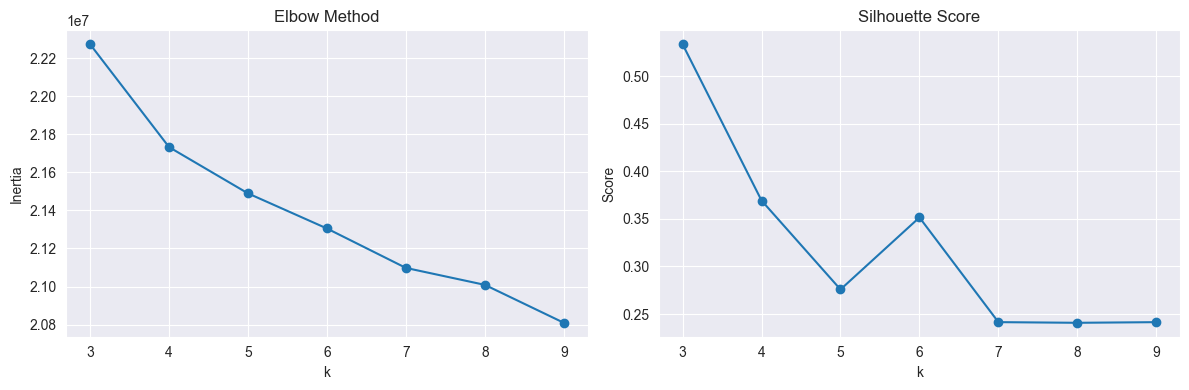

In [29]:
# Elbow + Silhouette
# ===============================================
inertias, silhouettes = [], []
K = range(3, 10)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    labels_tmp = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_pca, labels_tmp))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(K, inertias, marker='o')
ax[0].set_title("Elbow Method")
ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")
ax[1].plot(K, silhouettes, marker='o')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Score")
plt.tight_layout(); plt.show()


In [35]:
# best k
best_k = 3
print(f"Selected k = {best_k}")

Selected k = 3


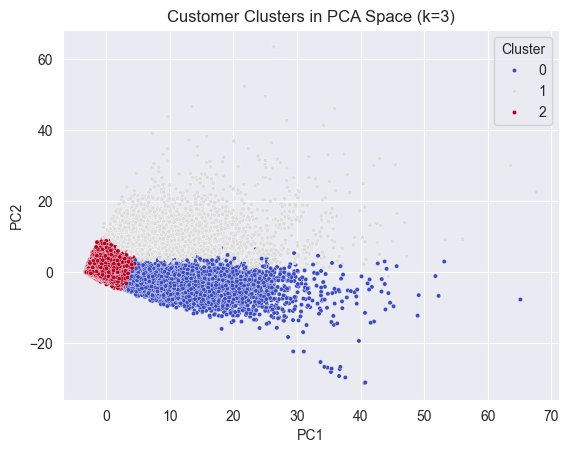

In [36]:
# K-Means
# ===============================================
kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_pca)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['Cluster'] = labels

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster',
                palette='coolwarm', s=10)
plt.title(f"Customer Clusters in PCA Space (k={best_k})")
plt.show()

In [37]:
# Cluster
# ===============================================
user_clusters = pd.DataFrame({'user_id': user_aisle.index, 'Cluster': labels})
print(user_clusters['Cluster'].value_counts())

Cluster
2    180527
0     20578
1      5104
Name: count, dtype: int64


C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\3423542742.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topAisles.values, y=topAisles.index, palette='viridis')


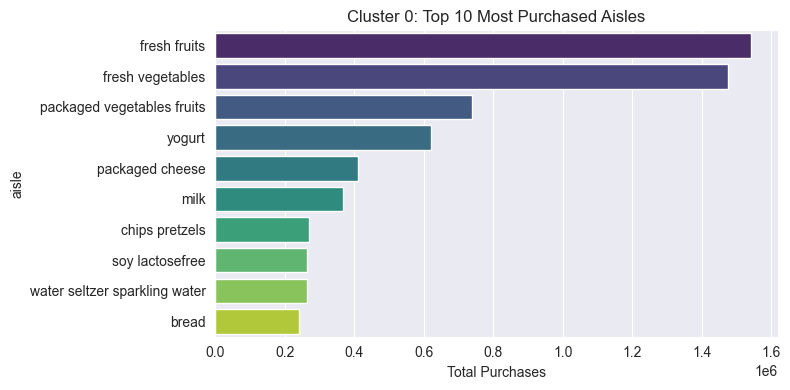

C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\3423542742.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topAisles.values, y=topAisles.index, palette='viridis')


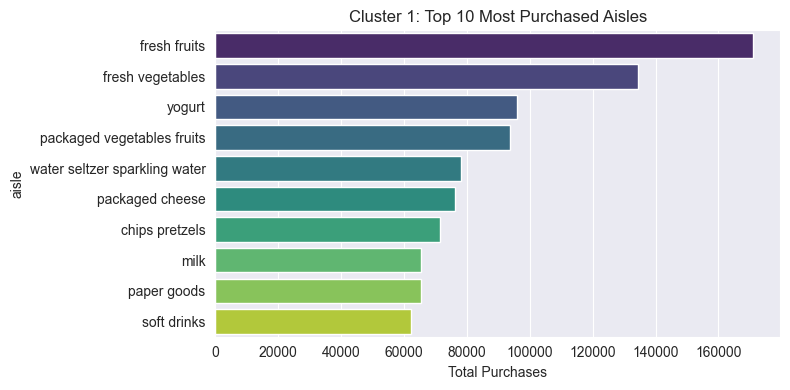

C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\3423542742.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topAisles.values, y=topAisles.index, palette='viridis')


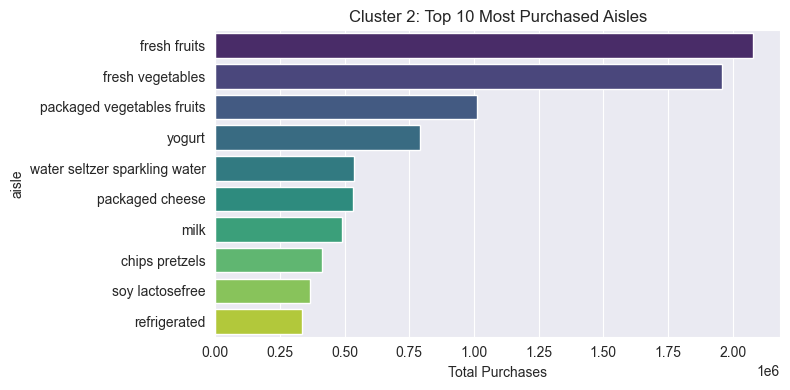

In [38]:
# Top aisles
# ===============================================
user_aisle['Cluster'] = labels

for k in range(best_k):
    cluster_data = user_aisle[user_aisle['Cluster'] == k].drop('Cluster', axis=1)
    topAisles = cluster_data.sum().sort_values(ascending=False).head(10)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=topAisles.values, y=topAisles.index, palette='viridis')
    plt.title(f"Cluster {k}: Top 10 Most Purchased Aisles")
    plt.xlabel("Total Purchases")
    plt.tight_layout()
    plt.show()

Clustering analysis Final version

In [68]:
df = full_data.copy()

In [69]:
# only work on prior and train data
df['days_since_prior_order'] = pd.to_numeric(df['days_since_prior_order'], errors='coerce')
df.loc[df['days_since_prior_order'] < 0, 'days_since_prior_order'] = np.nan

In [70]:
#feature engineering
# how they buy
# -----------------------------
user_orders = df.groupby('user_id').agg(
    total_orders=('order_number', 'max'),
    avg_days_between_orders=('days_since_prior_order', 'mean')
).reset_index()

# basket size
user_baskets = (
    df.groupby(['user_id', 'order_id'])
      .size()
      .groupby('user_id')
      .agg(avg_basket_size='mean', max_basket_size='max')
      .reset_index()
)

# reorder rate
user_reorder = (
    df.groupby('user_id')
      .agg(reorder_rate=('reordered', 'mean'))
      .reset_index()
)

# merge three above
user_behav = (
    user_orders
    .merge(user_baskets, on='user_id', how='left')
    .merge(user_reorder, on='user_id', how='left')
)
# order hour
user_time = (
    df.groupby('user_id')
      .agg(
          avg_order_hour=('order_hour_of_day', 'mean'),
          most_common_dow=('order_dow', lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan)
      ).reset_index()
)
user_behav = user_behav.merge(user_time, on='user_id', how='left')

In [71]:
print(user_baskets)
print(user_orders)
print(user_behav)
print(user_time)
print(user_behav)

        user_id  avg_basket_size  max_basket_size
0             1         6.363636               11
1             2        15.066667               31
2             3         7.333333               11
3             4         3.600000                7
4             5         9.200000               12
...         ...              ...              ...
206204   206205        12.750000               19
206205   206206         4.253731               24
206206   206207        13.937500               25
206207   206208        13.816327               28
206208   206209         9.785714               20

[206209 rows x 3 columns]
        user_id  total_orders  avg_days_between_orders
0             1            11                19.200000
1             2            15                18.009390
2             3            12                11.487179
3             4             5                15.357143
4             5             5                12.314286
...         ...           ...              

In [63]:
# 2) user x aisle（What they buy）
# -----------------------------
# use crosstab get every user's aisle order then normolaziation
cust_aisle_cnt = pd.crosstab(df['user_id'], df['aisle'])
cust_aisle_prop = cust_aisle_cnt.div(cust_aisle_cnt.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
print(cust_aisle_prop)

aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
1                      0.000000     0.000000          0.000000   
2                      0.000000     0.013274          0.000000   
3                      0.000000     0.000000          0.000000   
4                      0.000000     0.000000          0.000000   
5                      0.021739     0.086957          0.000000   
...                         ...          ...               ...   
206205                 0.000000     0.000000          0.019608   
206206                 0.000000     0.014035          0.000000   
206207                 0.000000     0.000000          0.000000   
206208                 0.000000     0.004431          0.000000   
206209                 0.000000     0.007299          0.000000   

aisle    baby bath body care  baby food formula  bakery desserts  \
user_id                                                            
1    

In [66]:
# concat stand behavior and userxwhat they buy matrix
# -----------------------------
behav_cols = ['total_orders', 'avg_days_between_orders',
              'avg_basket_size', 'max_basket_size',
              'reorder_rate', 'avg_order_hour']

behav_mat = user_behav.set_index('user_id')[behav_cols].copy()

# stand behavior
scaler = StandardScaler()
behav_scaled = pd.DataFrame(
    scaler.fit_transform(behav_mat),
    index=behav_mat.index,
    columns=behav_mat.columns
)

# concat + aisle percent
X_full = pd.concat([behav_scaled, cust_aisle_prop], axis=1).fillna(0)

print("Shape of behavior features:", behav_scaled.shape)
print("Shape of aisle proportions:", cust_aisle_prop.shape)
print("Shape of combined matrix:", X_full.shape)
print(X_full)

Shape of behavior features: (206209, 6)
Shape of aisle proportions: (206209, 134)
Shape of combined matrix: (206209, 140)
         total_orders  avg_days_between_orders  avg_basket_size  \
user_id                                                           
1           -0.313684                 0.503293        -0.619927   
2           -0.073619                 0.335380         0.870106   
3           -0.253668                -0.584453        -0.453907   
4           -0.673780                -0.038668        -1.093085   
5           -0.673780                -0.467805        -0.134318   
...               ...                      ...              ...   
206205      -0.733796                -0.130516         0.473473   
206206       3.047218                -1.634354        -0.981161   
206207      -0.013603                -0.106045         0.676783   
206208       1.966928                -1.154933         0.656037   
206209      -0.133635                 0.743501        -0.034038   

      

Components for ≥95% variance: 5 


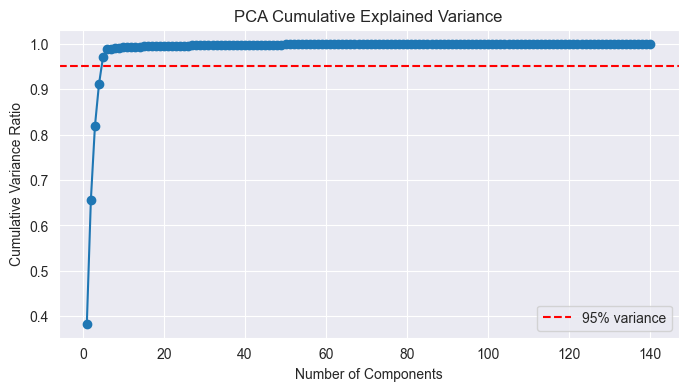

In [88]:
# PCA dimensionality reduction (≥95% cumulative explained variance)
# -----------------------------
pca = PCA(svd_solver='full', random_state=42)
pca.fit(X_full)
cum_var = np.cumsum(pca.explained_variance_ratio_)
n_95 = int(np.searchsorted(cum_var, 0.95) + 1)
n_components = min(n_95, 50)  # set a limit 50 incase over 100 again

print(f"Components for ≥95% variance: {n_95} ")

# visualize the cumulative explained variance
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel('Number of Components'); plt.ylabel('Cumulative Variance Ratio')
plt.title('PCA Cumulative Explained Variance'); plt.legend(); plt.show()

# dimensionality reduction
pca_final = PCA(n_components=5, svd_solver='full', random_state=42)
X_pca = pca_final.fit_transform(X_full)


In [86]:
print("X_full shape:", X_full.shape)
print("pca_final.components_ shape:", pca_final.components_.shape)

# loadings matrix
loadings = pd.DataFrame(
    pca_final.components_.T,
    index=X_full.columns,
    columns=[f'PC{i+1}' for i in range(pca_final.n_components_)]
)

# check if null
print("Loadings shape:", loadings.shape)
print(loadings.head())

# top 10 features
for i in range(pca_final.n_components_):
    top = loadings.iloc[:, i].abs().sort_values(ascending=False).head(10)
    print(f"\nTop 10 features contributing to PC{i+1} (|loading|):")
    print(top)


X_full shape: (206209, 140)
pca_final.components_ shape: (5, 140)
Loadings shape: (140, 5)
                              PC1       PC2       PC3       PC4       PC5
total_orders             0.504805 -0.333957  0.080098  0.128884  0.738801
avg_days_between_orders -0.433053  0.335928 -0.091341  0.766229  0.322467
avg_basket_size          0.345621  0.631444 -0.058591 -0.020095 -0.171480
max_basket_size          0.446964  0.532287 -0.038230 -0.059814  0.187253
reorder_rate             0.484301 -0.277880  0.035977  0.624898 -0.533820

Top 10 features contributing to PC1 (|loading|):
total_orders               0.504805
reorder_rate               0.484301
max_basket_size            0.446964
avg_days_between_orders    0.433053
avg_basket_size            0.345621
avg_order_hour             0.060754
fresh fruits               0.006745
fresh vegetables           0.005812
packaged produce           0.004687
yogurt                     0.004362
Name: PC1, dtype: float64

Top 10 features contributing

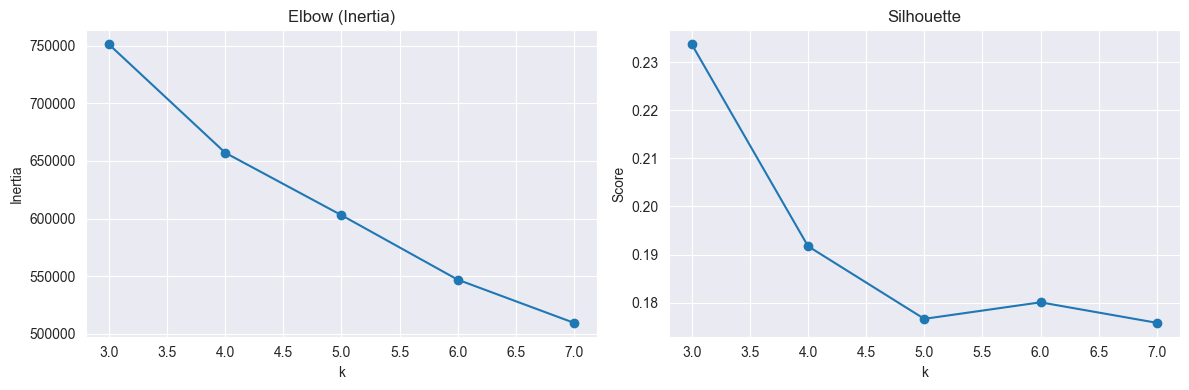

Chosen k by Silhouette peak: 3


In [53]:
# Elbow + Silhouette
# -----------------------------
K = range(3, 8)  # 你也可以扩到 (2..10) 看趋势
inertias, sils = [], []
for k in K:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++', random_state=42, batch_size=2048)
    labels_tmp = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_pca, labels_tmp))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(list(K), inertias, marker='o'); ax[0].set_title("Elbow (Inertia)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")
ax[1].plot(list(K), sils, marker='o'); ax[1].set_title("Silhouette")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Score")
plt.tight_layout(); plt.show()


best_k = int(K[np.argmax(sils)])
print(f"Chosen k by Silhouette peak: {best_k}")


In [54]:
# fit the final model and generate cluster label
# -----------------------------
kmodel = MiniBatchKMeans(n_clusters=best_k, init='k-means++', random_state=42, batch_size=2048)
cluster_labels = kmodel.fit_predict(X_pca)
# print out
user_cluster = pd.DataFrame({'user_id': X_full.index, 'cluster': cluster_labels})
print(user_cluster['cluster'].value_counts().sort_index())

cluster
0    100898
1     42769
2     62542
Name: count, dtype: int64


C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\2773387325.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aisle_scores.values, y=aisle_scores.index, palette='viridis')


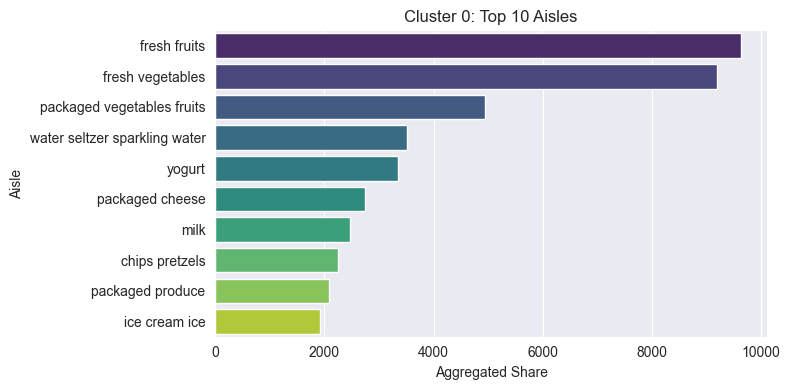

C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\2773387325.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aisle_scores.values, y=aisle_scores.index, palette='viridis')


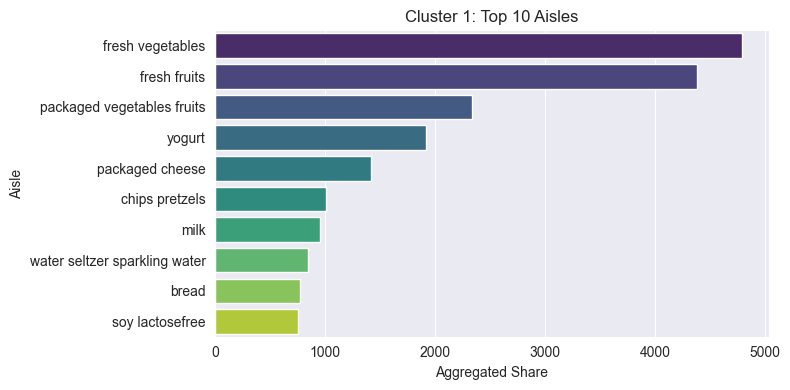

C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\2773387325.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aisle_scores.values, y=aisle_scores.index, palette='viridis')


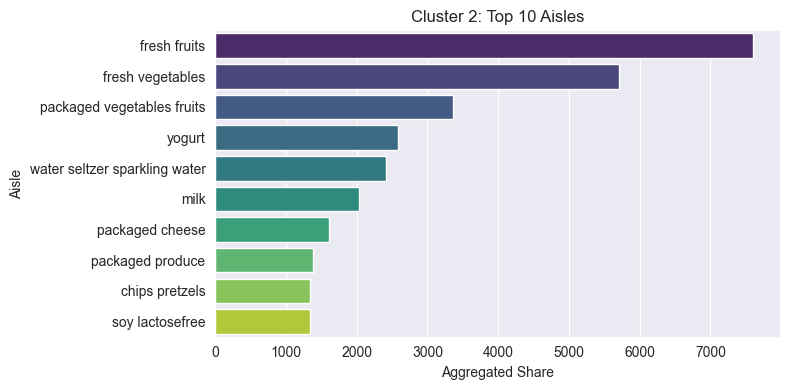

Behavioral feature means by cluster:


,total_orders,avg_days_between_orders,avg_basket_size,max_basket_size,reorder_rate,avg_order_hour
cluster,,,,,,
0,7.42,19.51,7.68,12.98,0.31,13.81
1,15.83,15.22,18.42,32.06,0.50,13.55
2,30.71,9.66,7.94,16.39,0.62,13.13


In [90]:
# Cluster profiling: Top aisles & average behavioral features

# top 10 aisles in each cluster
cust_prop_with_cluster = cust_aisle_prop.merge(user_cluster.set_index('user_id'),
                                               left_index=True, right_index=True)

for c in sorted(user_cluster['cluster'].unique()):
    sub = cust_prop_with_cluster[cust_prop_with_cluster['cluster'] == c].drop(columns='cluster')
    aisle_scores = sub.sum(axis=0).sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=aisle_scores.values, y=aisle_scores.index, palette='viridis')
    plt.title(f"Cluster {c}: Top 10 Aisles")
    plt.xlabel("Aggregated Share"); plt.ylabel("Aisle")
    plt.tight_layout(); plt.show()

# behavioral feature means by cluster
behav_with_cluster = behav_mat.merge(user_cluster.set_index('user_id'),
                                     left_index=True, right_index=True)

behav_summary = (
    behav_with_cluster
    .groupby('cluster')[behav_cols]
    .mean()
    .round(2)
    .sort_index()
)
print("Behavioral feature means by cluster:")
display(behav_summary)



C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\627586496.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prods.values, y=prods.index, palette='mako')


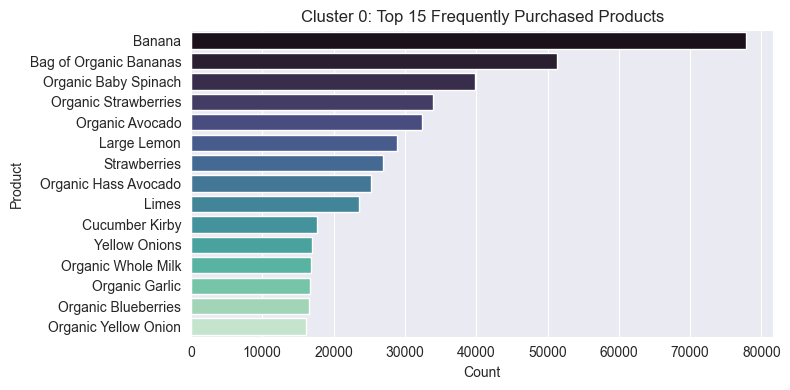

C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\627586496.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prods.values, y=prods.index, palette='mako')


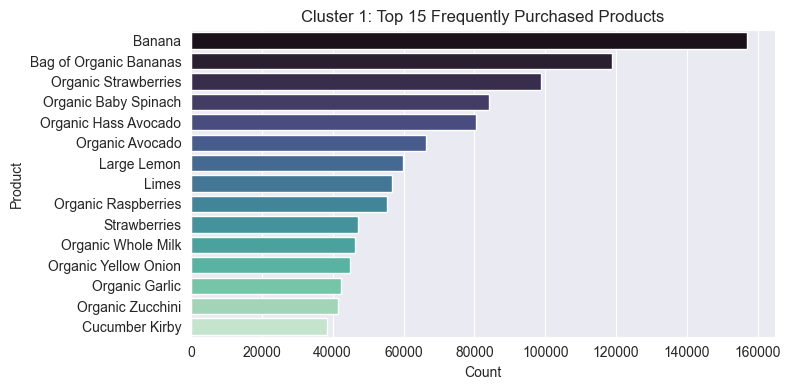

C:\Users\JunhuiHuTEST\AppData\Local\Temp\ipykernel_19432\627586496.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prods.values, y=prods.index, palette='mako')


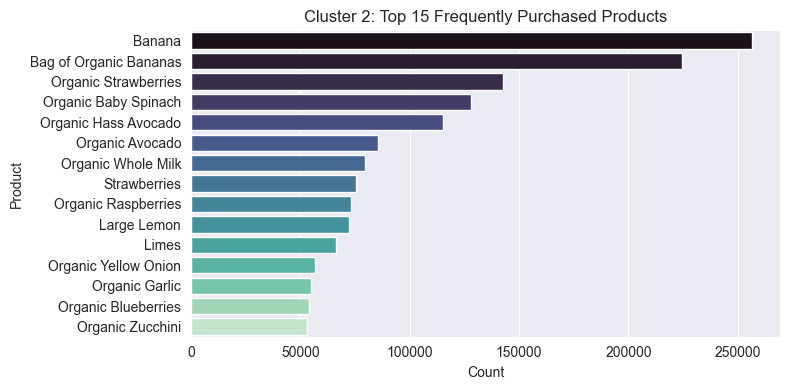

In [56]:
# write the cluster labels back to full_data

full_with_cluster = df[['user_id','order_id','aisle','department','product_name']].copy()
full_with_cluster = full_with_cluster.merge(user_cluster, on='user_id', how='left')

# top 15 products with the highest repurchase tendency
topN = 15
for c in sorted(user_cluster['cluster'].unique()):
    subp = full_with_cluster.loc[full_with_cluster['cluster']==c, 'product_name']
    prods = subp.value_counts().head(topN)
    plt.figure(figsize=(8,4))
    sns.barplot(x=prods.values, y=prods.index, palette='mako')
    plt.title(f"Cluster {c}: Top {topN} Frequently Purchased Products")
    plt.xlabel("Count"); plt.ylabel("Product")
    plt.tight_layout(); plt.show()